In [1]:
import csv
import os

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.constants import (epsilon_0 as eps_0, mu_0, pi)
import seaborn as sns

from source.utils import load_tissue_diel_properties
from source.config import fig_config, fig_config_reset
from source.bhte import (initT_depth_analytic,
                         deltaT_depth_analytic,
                         deltaT_depth_pstd,
                         deltaT_3d_pstd)

In [2]:
## parameters
# dry skin bhte parameters from IT'IS database
# https://itis.swiss/virtual-population/tissue-properties/database/
k = 0.37       # thermal conductivity [W/m/°C]
rho = 1109.    # dry skin density [kg/m^3]
C = 3391.      # specific heat of dry skin [Ws/kg/°C]
m_b = 1.76e-6  # blood perfusion [m^3/kg/s] in SI units and 106 mL/min/kg in physiology literature units

# for blood
k_b = 0.52     # thermal conductivity [W/m/°C]
rho_b = 1000.  # kg/m^3
C_b = 3617.    # specific heat of blood [J/kg/°C]

# additional parameters
h_0 = 10.      # heat convection coefficient [W/m^2/°C] between the skin surface and the surrounding air
T_a = 37.      # arterial temperature [°C]     
T_c = 37.      # body core temperature [°C]
T_f = 25.      # surrounding air temperature [°C]
Q_m = 33800.   # metabolic heat generation [W/m^3]

In [3]:
## model input
# frequency
f = 10e9

# conductivity, relative permitivity, tangent loss and penetration depth (Gabriel et al. 1996)
sigma, eps_r, tan_loss, pen_depth = load_tissue_diel_properties('skin_dry', f)

# `pen_depth` is the energy penetration depth into tissue, which is defined as the distance 
# beneath the surface at which the SAR has fallen to a factor of 1/e below that at the surface;
# one-half of the more commonly reported wave penetration depth
pen_depth = pen_depth / 2

# air (vacuum) resistance 
Z_air = np.sqrt(mu_0 / eps_0)

# dry skin resistance
Z_skin_dry = np.sqrt(mu_0 / (eps_r * eps_0))

# energy (Fresnel) transmission coefficient into the tissue
T_tr = 2 * Z_skin_dry / (Z_air + Z_skin_dry)

# I0 T_Tr = 10 W/m^2 at 6 GHz
I0 = 10. / T_tr

In [4]:
## 1-D simulation
# exposure time in seconds
T = 360
t = np.linspace(0, T, 100)

# simulation
N = 101
deltaT = deltaT_depth_pstd(t, N, pen_depth, k, rho, C, m_b * 3, I0, T_tr)

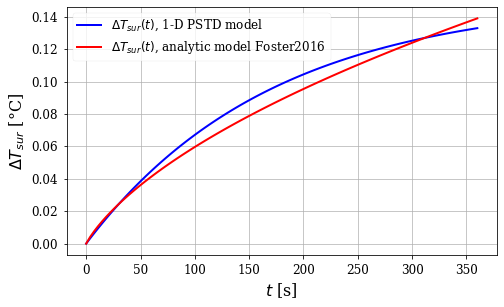

In [5]:
# temperature change on the skin surface
fig_config(scaler=1.5)
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(t, deltaT[:, 0], 'b-', linewidth=2, label='$\\Delta T_{sur}(t)$, 1-D PSTD model')
ax.plot(t, deltaT_depth_analytic(t, pen_depth, k, rho, C, I0, T_tr), 'r-', linewidth=2, label='$\\Delta T_{sur}(t)$, analytic model Foster2016')
ax.set_xlabel('$t$ [s]')
ax.set_ylabel('$\\Delta T_{sur}$ [°C]')
ax.legend(loc='upper left')
ax.grid()
plt.tight_layout()
plt.show()

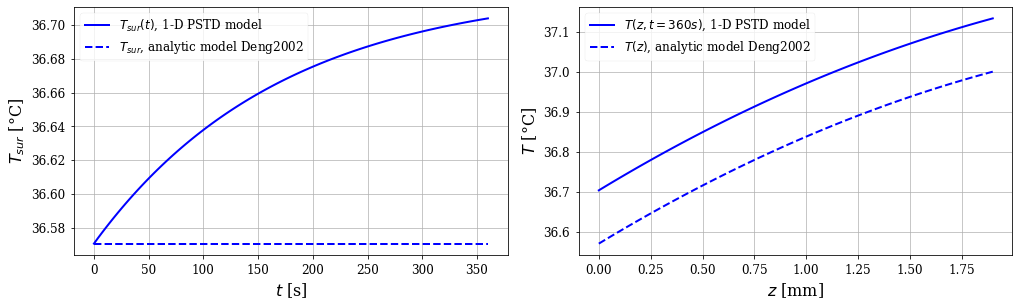

In [6]:
# visualize the temperature before and after mmWave exposure
dx = pen_depth / N
z = np.linspace(0, pen_depth, N)
T0 = initT_depth_analytic(z, k, rho, C, rho_b, C_b, m_b, h_0, T_a, T_c, T_f, Q_m)
T = T0 + deltaT

fig_config(nrows=1, ncols=2, scaler=1.5)
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(t, T[:, 0], 'b-', linewidth=2, label='$T_{sur}(t)$, 1-D PSTD model')
ax1.plot(t, np.ones_like(t) * T0[0], 'b--', linewidth=2, label='$T_{sur}$, analytic model Deng2002')
ax1.set_xlabel('$t$ [s]')
ax1.set_ylabel('$T_{sur}$ [°C]')
ax1.legend(loc='upper left')
ax1.grid()

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(z * 1e3, T[-1, :], 'b-', linewidth=2, label=f'$T(z, t={int(t[-1])} s)$, 1-D PSTD model')
ax2.plot(z * 1e3, T0, 'b--', linewidth=2, label='$T(z)$, analytic model Deng2002')
ax2.set_xlabel('$z$ [mm]')
ax2.set_ylabel('$T$ [°C]')
ax2.legend(loc='upper left')
ax2.grid()
plt.tight_layout()
plt.show()

In [7]:
## proper orthogonal decomposition
U, S, VT = np.linalg.svd(deltaT.T)

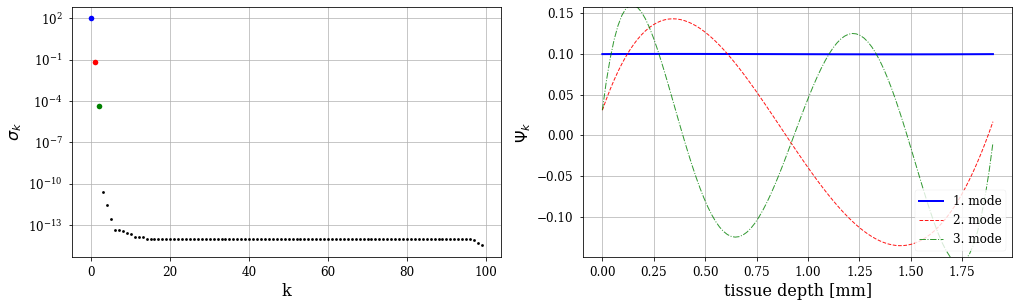

In [8]:
# the most significant orthogonal modes in the model
fig_config(nrows=1, ncols=2, scaler=1.5)
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax1.semilogy(100 * S / np.sum(S), 'k.')
ax1.semilogy(0, 100 * S[0] / np.sum(S), 'bo')
ax1.semilogy(1, 100 * S[1] / np.sum(S), 'ro')
ax1.semilogy(2, 100 * S[2] / np.sum(S), 'go')
ax1.set_xlabel('k')
ax1.set_ylabel('$\\sigma_k$')
ax1.grid()

colors = ['b', 'r', 'g']
linestyles = ['-', '--', '-.']
linewidths = [2, 1, 1]
alphas = [1, 0.9, 0.8]
ax2 = fig.add_subplot(1, 2, 2)
for idx, (c, ls, lw, alpha) in enumerate(zip(colors, linestyles, linewidths, alphas)):
    ax2.plot(z * 1e3, np.real(U[:, idx]), c=c, linewidth=lw, linestyle=ls, alpha=alpha, label=f'{idx + 1}. mode')
ax2.set_ylim(1.1 * np.min(U[:, 1].real), 1.1 * np.max(U[:, 1].real))
ax2.set_xlabel('tissue depth [mm]')
ax2.set_ylabel('$\\Psi_k$')
ax2.grid()
ax2.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [16]:
## 3-D simulation
sim_time = 860
t = np.linspace(0, sim_time, 50)
N = [31] * 3
area = (0.02, 0.02)
SAR_ref = I0 * T_tr / (rho * pen_depth)
x = np.linspace(-area[0]/2, area[0]/2, N[0])
y = np.linspace(-area[1]/2, area[1]/2, N[1])
SAR_sur = SAR_ref * np.exp(-(x**2 + y.reshape(-1, 1)**2) / (2 * (SAR_ref * 3e-4)**2))
T = deltaT_3d_pstd(t, N, area, pen_depth, k, rho, C, m_b * 3, SAR_sur)
# np.save(os.path.join('simulations', f'deltaT_Nx{N[0]}Ny{N[1]}Nz{N[2]}_t{sim_time}_a{int(area[0]*area[1]*1e4)}.npy'), T, allow_pickle=True, fix_imports=True)

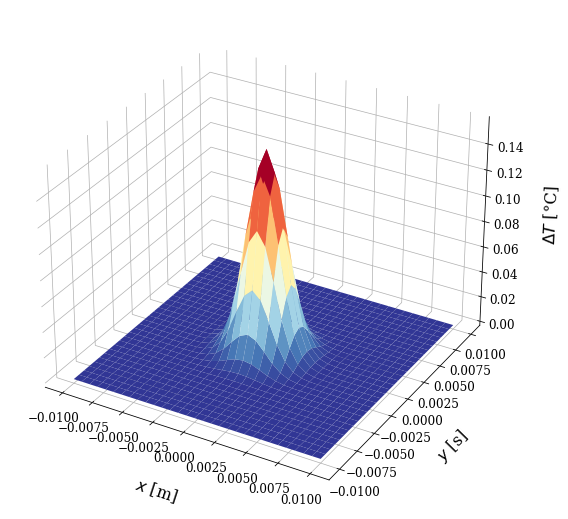

In [17]:
# temperature change distribution on the surface, 3-D plot
x = np.linspace(-area[0]/2, area[0]/2, N[0])
y = np.linspace(-area[0]/2, area[1]/2, N[1])
xmesh, ymesh = np.meshgrid(x, y)

fig_config(scaler=2.5)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20
ax.zaxis.labelpad = 20
ax.w_xaxis.set_pane_color((0, 0, 0))
ax.w_yaxis.set_pane_color((0, 0, 0))
ax.w_zaxis.set_pane_color((0, 0, 0))
# ax.plot_trisurf(xmesh.ravel(), ymesh.ravel(), T[-1, :, :, 0].ravel(), cmap='RdYlBu_r', antialiased=False)
ax.plot_surface(xmesh, ymesh, T[-1, :, :, 0], cmap='RdYlBu_r', antialiased=True)
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$y$ [s]')
ax.set_zlabel('$\\Delta T$ [°C]')
plt.tight_layout()
plt.show()

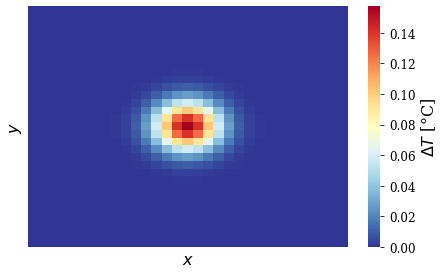

In [18]:
# temperature change distribution on the surface, heatmap
fig_config(scaler=1.5)
fig = plt.figure()
ax = fig.add_subplot(111)
ax = sns.heatmap(T[-1, :, :, 0], cmap='RdYlBu_r', xticklabels=False, yticklabels=False,
                 cbar_kws={'label': '$\\Delta T$ [°C]', 'orientation': 'vertical',})
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.show()

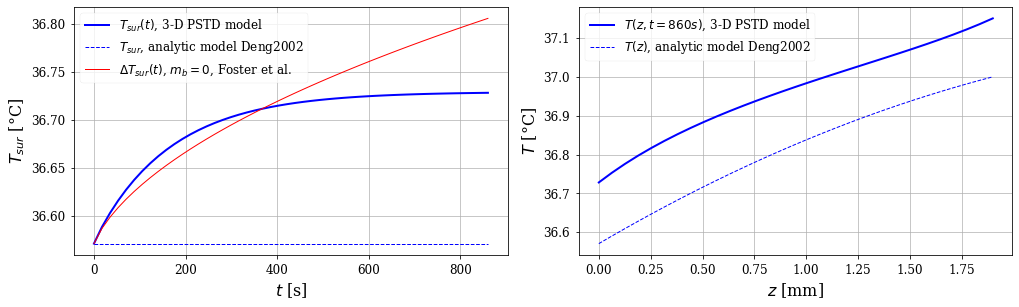

In [19]:
# temperature (depth-wise) before and after mmWave exposure
z = np.linspace(0, pen_depth, N[2])
T0 = initT_depth_analytic(z, k, rho, C, rho_b, C_b, m_b, h_0, T_a, T_c, T_f, Q_m)

fig_config(nrows=1, ncols=2, scaler=1.5)
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(t, np.ones_like(t) * T0[0] + np.max(T[:, :, :, 0], axis=(1, 2)), 'b-', linewidth=2, label='$T_{sur}(t)$, 3-D PSTD model')
ax1.plot(t, np.ones_like(t) * T0[0], 'b--', linewidth=1, label='$T_{sur}$, analytic model Deng2002')
ax1.plot(t, np.ones_like(t) * T0[0] + deltaT_depth_analytic(t, pen_depth, k, rho, C, I0, T_tr), 'r-', linewidth=1, label='$\\Delta T_{sur}(t)$, $m_b = 0$, Foster et al.')
ax1.set_xlabel('$t$ [s]')
ax1.set_ylabel('$T_{sur}$ [°C]')
ax1.legend(loc='upper left')
ax1.grid()

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(z * 1e3, T0 + T[-1, N[2]//2, N[2]//2, :], 'b-', linewidth=2, label=f'$T(z, t={{{int(t[-1])}}} s)$, 3-D PSTD model')
ax2.plot(z * 1e3, T0, 'b--', linewidth=1, label='$T(z)$, analytic model Deng2002')
ax2.set_xlabel('$z$ [mm]')
ax2.set_ylabel('$T$ [°C]')
ax2.legend(loc='upper left')
ax2.grid()
plt.tight_layout()
plt.show()